In [1]:
%env DDE_BACKEND=tensorflow
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

env: DDE_BACKEND=tensorflow


Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
rho = 1
mu = 1
u_in = 1.5
D = 2
L = 10
tle = 10
v_i = 0
tau_0 = 10

# Papasnastasiou approximation
m = 10

In [3]:
geom = dde.geometry.Rectangle(xmin=[-L/2,-D/2],xmax=[L/2,D/2])

In [4]:
def upper_wall(X, on_boundary):
  # on_upper_wall = np.logical_and(np.isclose(X[1],D/2,rtol=1e-05,atol=1e-08), np.not_equal(X[0],-L/2), on_boundary)
  on_upper_wall = np.logical_and(np.logical_and(np.isclose(X[1],D/2,rtol=1e-05,atol=1e-08), np.not_equal(X[0],-L/2)), on_boundary)
  return on_upper_wall

def lower_wall(X, on_boundary):
  # on_lower_wall = np.logical_and(np.isclose(X[1],-D/2,rtol=1e-05,atol=1e-08), np.not_equal(X[0],-L/2),on_boundary)
  on_lower_wall = np.logical_and(np.logical_and(np.isclose(X[1],-D/2,rtol=1e-05,atol=1e-08), np.not_equal(X[0],-L/2)),on_boundary)
  return on_lower_wall

def boundary_inlet(X,on_boundary):
  on_inlet = np.logical_and(np.isclose(X[0],-L/2,rtol=1e-05,atol=1e-08),on_boundary)
  return on_inlet

def boundary_outlet(X,on_boundary):
  on_outlet = np.logical_and(np.isclose(X[0],L/2,rtol=1e-05,atol=1e-08),on_boundary)
  return on_outlet

In [5]:
bc_wall_u_up = dde.DirichletBC(geom, lambda X:v_i, upper_wall, component =0)
bc_wall_u_down = dde.DirichletBC(geom, lambda X:0., lower_wall, component =0)
bc_wall_v_up = dde.DirichletBC(geom, lambda X:0., upper_wall, component =1)
bc_wall_v_down = dde.DirichletBC(geom, lambda X:0., lower_wall, component =1)

bc_inlet_u = dde.DirichletBC(geom, lambda X:u_in, boundary_inlet, component =0)
bc_inlet_v = dde.DirichletBC(geom, lambda X:0., boundary_inlet, component =1)

bc_outlet_p = dde.DirichletBC(geom, lambda X:0., boundary_outlet, component =2)
bc_outlet_v = dde.DirichletBC(geom, lambda X:0., boundary_outlet, component =1)

In [6]:
def pde(X, Y):
    du_x = dde.grad.jacobian(Y, X, i=0, j=0)
    du_y = dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x = dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y = dde.grad.jacobian(Y, X, i=1, j=1)
    dp_x = dde.grad.jacobian(Y, X, i=2, j=0)
    dp_y = dde.grad.jacobian(Y, X, i=2, j=1)
    # du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    # du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    # dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    # dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)

    # Definições para Bingham para componentes do tensor de tensão
    tau_xy = tau_0 * (1 - tf.exp(- m * (du_y + dv_x))) + mu * (du_y + dv_x)
    tau_yx = tau_0 * (1 - tf.exp(- m * (dv_x + du_y))) + mu * (dv_x + du_y)
    tau_xx = tau_0 * (1 - tf.exp(- m * (du_x + du_x))) + mu * (du_x + du_x)
    tau_yy = tau_0 * (1 - tf.exp(- m * (dv_y + du_y))) + mu * (dv_y + du_y)
    # tau_xy = tau_0 * (1 - np.exp(- m * (du_y + dv_x))) + mu * (du_y + dv_x)
    # tau_yx = tau_0 * (1 - np.exp(- m * (dv_x + du_y))) + mu * (dv_x + du_y)
    # tau_xx = tau_0 * (1 - np.exp(- m * (du_x + du_x))) + mu * (du_x + du_x)
    # tau_yy = tau_0 * (1 - np.exp(- m * (dv_y + du_y))) + mu * (dv_y + du_y)

    # tau_diff = tau_xy - tau_0
    # H_tau = tf.where(tau_diff > 0, 1.0, 0.0)
    # dv_x = dde.grad.jacobian(Y, X, i=0, j=0) * H_tau
    # du_y = dde.grad.jacobian(Y, X, i=0, j=1) * H_tau
    
    # tau_xy = tau_0 + mu * (du_y + dv_x)
    # tau_yx = tau_0 + mu * (dv_x + du_y)
    # tau_xx = tau_0 + mu * (du_x + du_x)
    # tau_yy = tau_0 + mu * (dv_y + du_y)

    # Derivadas dos tensores de tensão
    dtau_xy_y = dde.grad.jacobian(tau_xy, X, i=0, j=1)
    dtau_yx_x = dde.grad.jacobian(tau_yx, X, i=0, j=0)
    dtau_xx_x = dde.grad.jacobian(tau_xx, X, i=0, j=0)
    dtau_yy_y = dde.grad.jacobian(tau_yy, X, i=0, j=1)

    # Equações de Navier-Stokes modificadas para incluir todos os tensores de tensão
    pde_u = rho * (Y[:,0:1] * du_x + Y[:,1:2] * du_y) + dp_x - dtau_yx_x - dtau_xx_x
    pde_v = rho * (Y[:,0:1] * dv_x + Y[:,1:2] * dv_y) + dp_y - dtau_xy_y - dtau_yy_y
    pde_cont = du_x + dv_y  # Equação de continuidade

    return [pde_u, pde_v, pde_cont]


In [7]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_wall_u_up,bc_wall_u_down,bc_wall_v_up,bc_wall_v_down,bc_inlet_u,bc_inlet_v,bc_outlet_p,bc_outlet_v],
                    num_domain = 10000,
                    num_boundary = 10000,
                    num_test = 20000)

<function matplotlib.pyplot.show(close=None, block=None)>

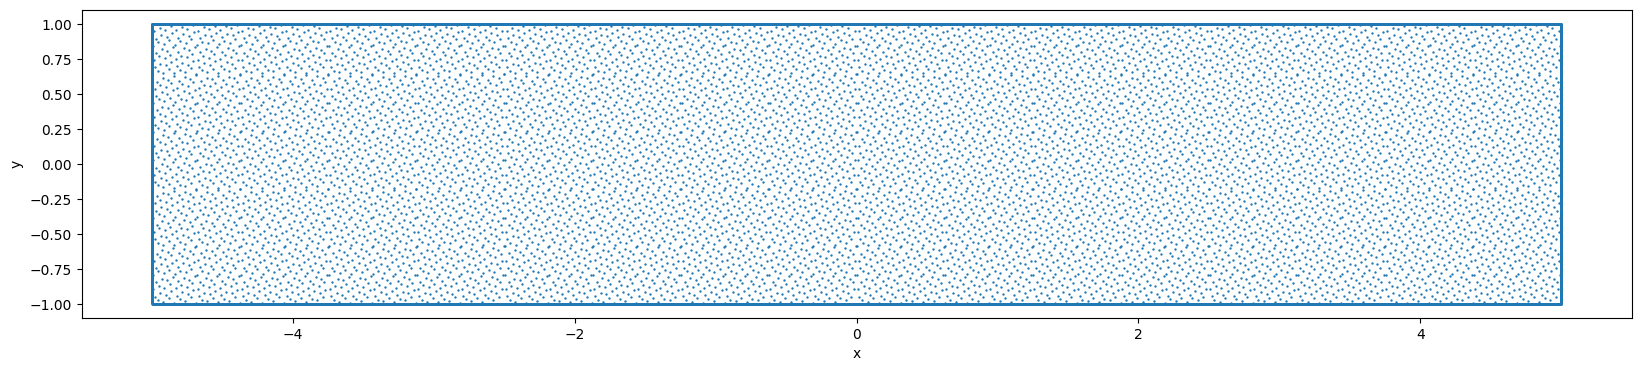

In [8]:
plt.figure(figsize=(20,4))
plt.scatter(data.train_x_all[:,0],data.train_x_all[:,1],s=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show

In [9]:
net = dde.maps.FNN([2]+[84]*6+[3], "tanh","Glorot uniform")

In [10]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
'compile' took 0.004133 s



In [11]:
losshistory,train_state = model.train(epochs = 10000, display_every=100)

Training model...



c:\Users\Matuchaki\AppData\Local\pypoetry\Cache\virtualenvs\deepxde-custom-E_cFIhQu-py3.10\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Cause: could not parse the source code of <function <lambda> at 0x0000021B63618820>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x0000021B63618820>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x0000021B63618B80>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x0000021B63

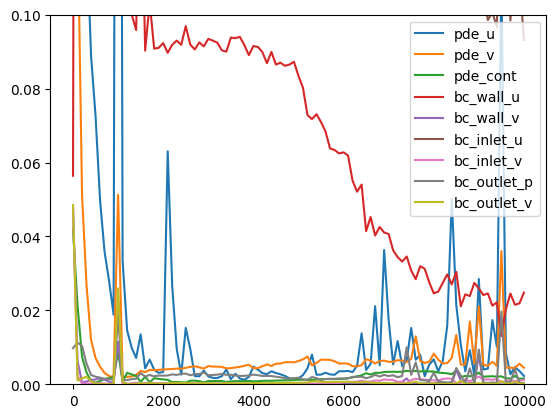

In [12]:
import matplotlib.pyplot as plt

plot_array = np.array(losshistory.loss_test)
plot_labels = ["pde_u", "pde_v", "pde_cont", "bc_wall_u", "bc_wall_v", "bc_inlet_u", "bc_inlet_v", "bc_outlet_p", "bc_outlet_v"]
# plot_array = np.array(losshistory.loss_train)
for i in range(plot_array.shape[1]):
    plt.plot(losshistory.steps, plot_array[:,i], label=plot_labels[i])
    
plt.legend()
plt.ylim([0, 0.1])
plt.show()

In [13]:
dde.optimizers.config.set_LBFGS_options(maxiter = 1000)
model.compile("L-BFGS")
losshistory,train_state = model.train()
dde.saveplot(losshistory, train_state, issave = False , isplot = False)

Compiling model...
'compile' took 4.961794 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
10000     [2.46e-03, 4.32e-03, 1.50e-03, 2.48e-02, 2.21e-04, 9.32e-02, 1.22e-03, 3.71e-04, 2.07e-04]    [2.26e-03, 4.47e-03, 1.59e-03, 2.48e-02, 2.21e-04, 9.32e-02, 1.22e-03, 3.71e-04, 2.07e-04]    []  
11000     [2.40e-03, 2.64e-03, 1.73e-03, 4.89e-03, 7.57e-04, 3.47e-02, 1.58e-03, 1.72e-04, 1.64e-04]    [3.70e-03, 3.41e-03, 2.33e-03, 4.89e-03, 7.57e-04, 3.47e-02, 1.58e-03, 1.72e-04, 1.64e-04]    []  

Best model at step 11000:
  train loss: 4.90e-02
  test loss: 5.17e-02
  test metric: []

'train' took 15014.434211 s



In [14]:
samples= geom.random_points(500000)
result = model.predict(samples)

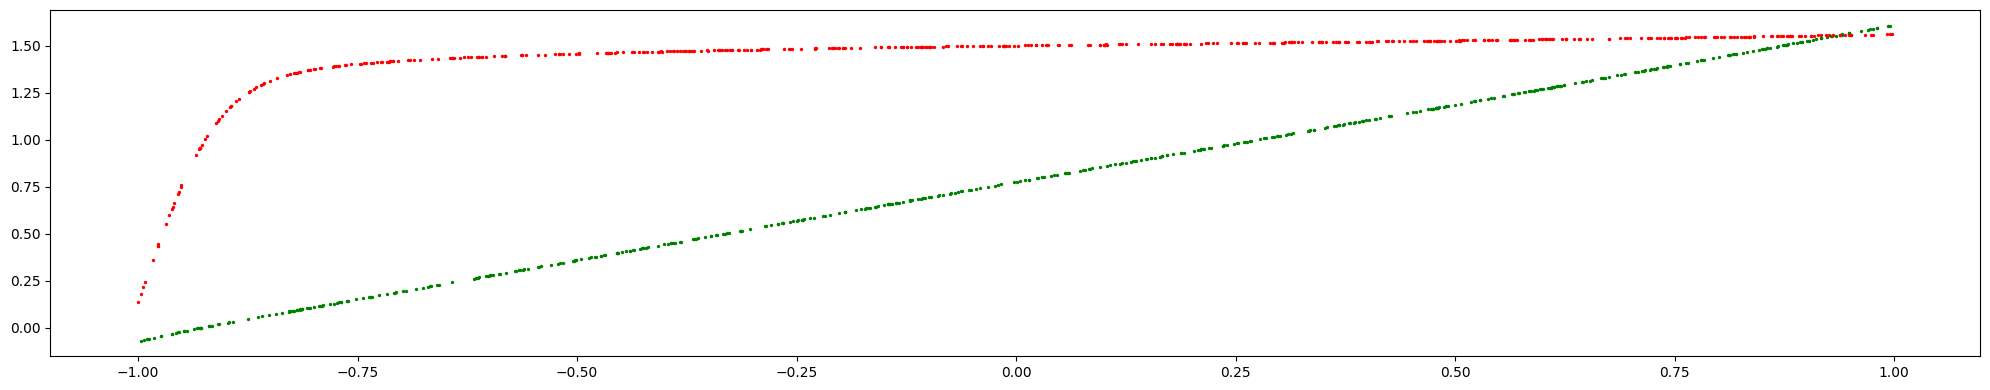

In [15]:
color_legend=[[0,1.5],[-0.3,0.3],[0,35]]
# for idx in range(3):
plt.figure(figsize=(20,4))
mask = np.where((samples[:,0] > 4.9) & (samples[:,0] < 4.91))
plt.scatter(samples[mask,1], result[mask,0], c='green',s=2)
mask = np.where((samples[:,0] < -4.9) & (samples[:,0] > -4.91))
plt.scatter(samples[mask,1], result[mask,0], c='red',s=2)
plt.tight_layout()
plt.show()

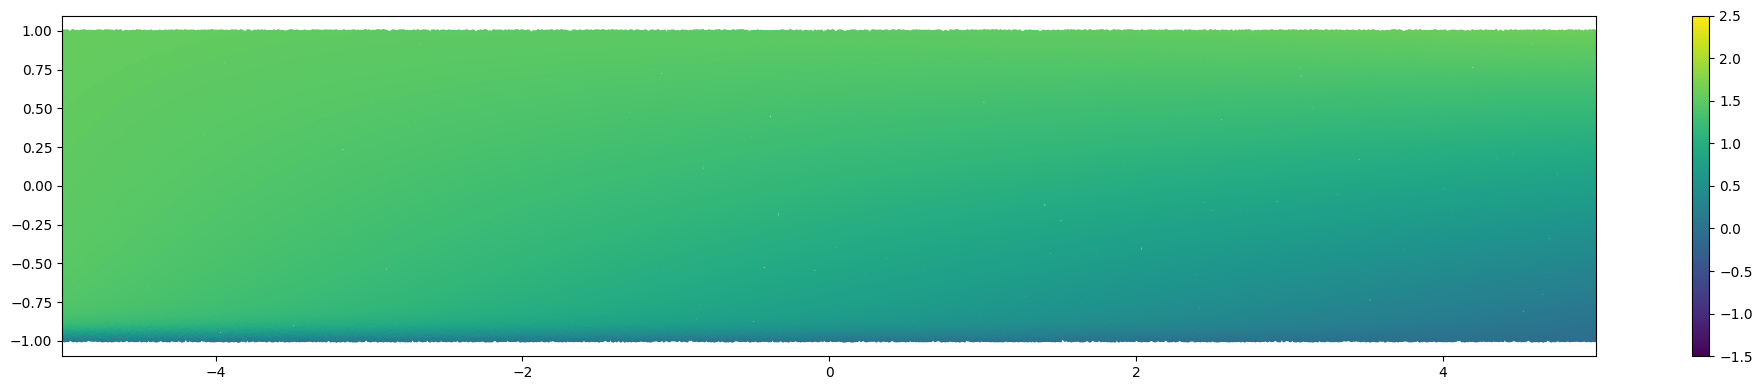

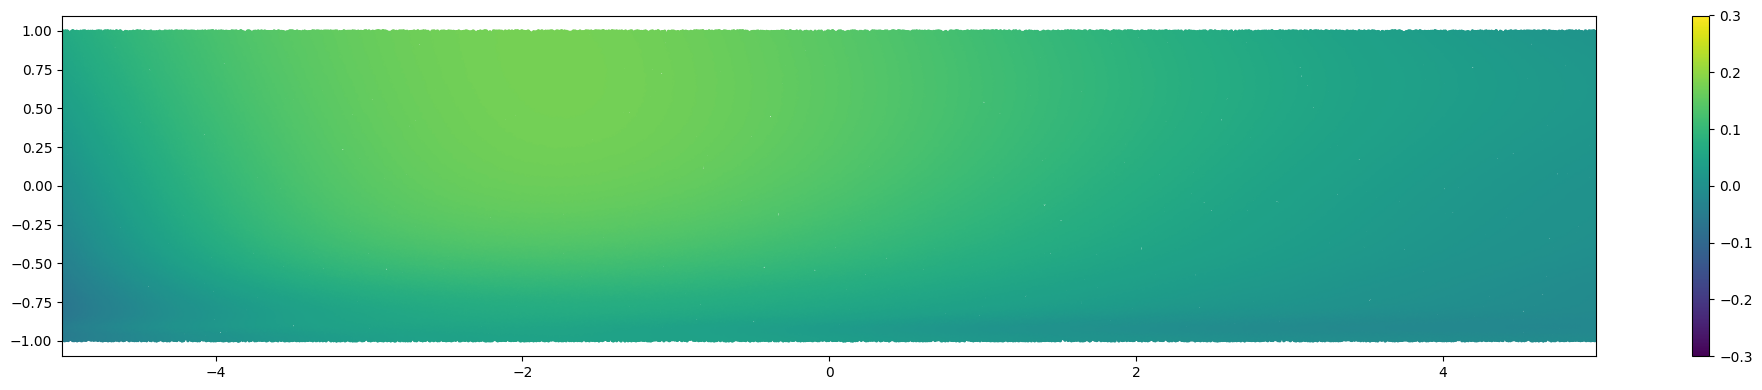

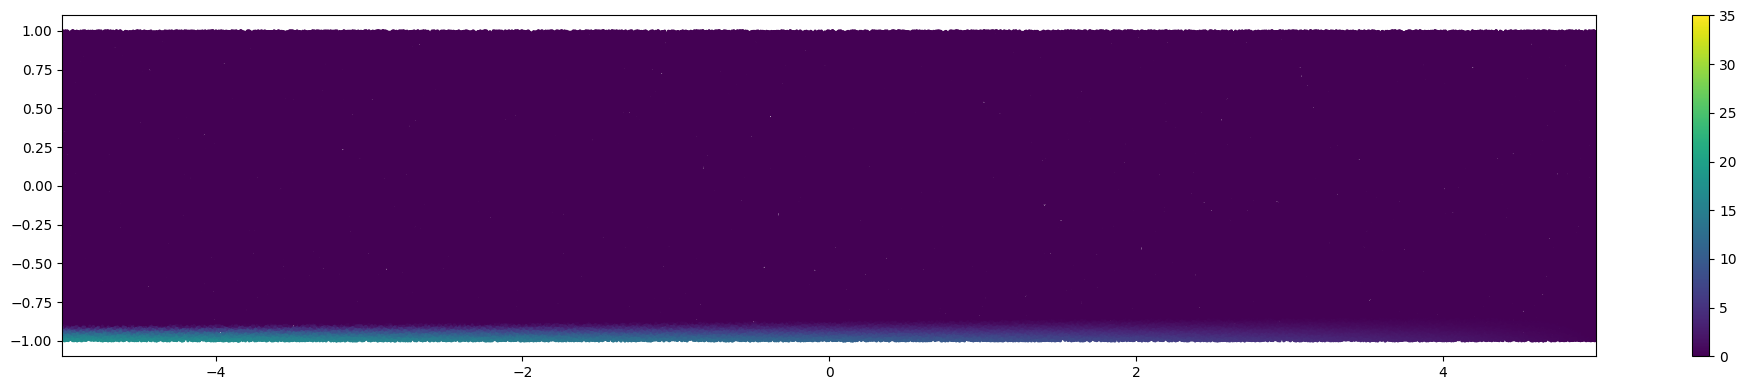

In [16]:
color_legend=[[-1.5,2.5],[-0.3,0.3],[0,35]]
for idx in range(3):
  plt.figure(figsize=(20,4))
  plt.scatter(samples[:,0], samples[:,1], c=result[:,idx], cmap='viridis',s=2)
  plt.colorbar()
  plt.clim(color_legend[idx])
  plt.xlim((0-D/2,D-D/2))
  plt.xlim((0-L/2,L-L/2))
  plt.tight_layout()
  plt.show()